## Problem 2: Monte Carlo Sampling of Random Variables
(1). Generate random samples from the Gamma distribution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# For reproducibility
np.random.seed(123)

# Define a function to generate Gamma samples
# using SciPy's built-in gamma.rvs(...)
# alpha = shape, scale = 1/beta in SciPy convention.
def generate_gamma_samples(alpha, beta, n_samples=10000):
    """
    Generate random samples from a Gamma(alpha, beta) distribution
    where 'beta' is the 'rate' parameter.
    """
    scale = 1.0 / beta
    samples = gamma.rvs(a=alpha, scale=scale, size=n_samples)
    return samples

# Example usage:
alpha1, beta1 = 2.0, 1.0   # e.g. shape=2, rate=1
alpha2, beta2 = 5.0, 0.5   # shape=5, rate=0.5
alpha3, beta3 = 3.0, 2.0   # shape=3, rate=2

# Generate samples for each set
samples1 = generate_gamma_samples(alpha1, beta1)
samples2 = generate_gamma_samples(alpha2, beta2)
samples3 = generate_gamma_samples(alpha3, beta3)

print("Sample Means:",
      np.mean(samples1), np.mean(samples2), np.mean(samples3))
print("Sample Variances:",
      np.var(samples1), np.var(samples2), np.var(samples3))

Sample Means: 2.0163313092651993 9.954941017964758 1.4963598445587538
Sample Variances: 2.0136237564443196 20.386564425586833 0.7631541687998311


## (2). Parameters

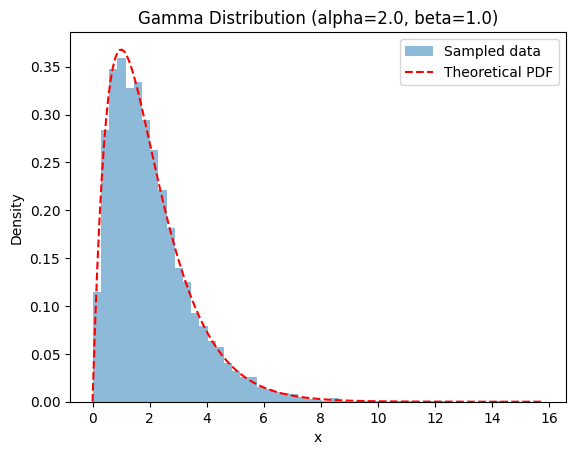

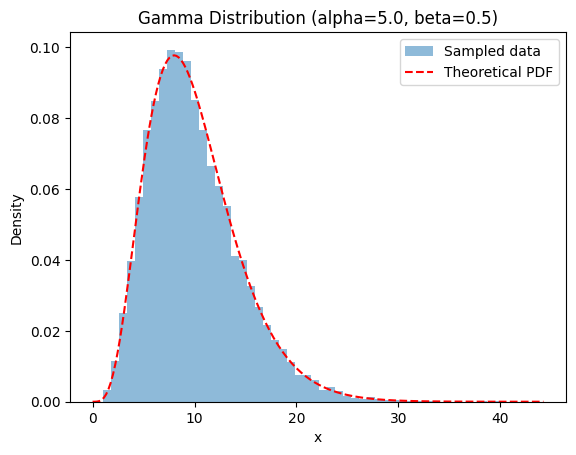

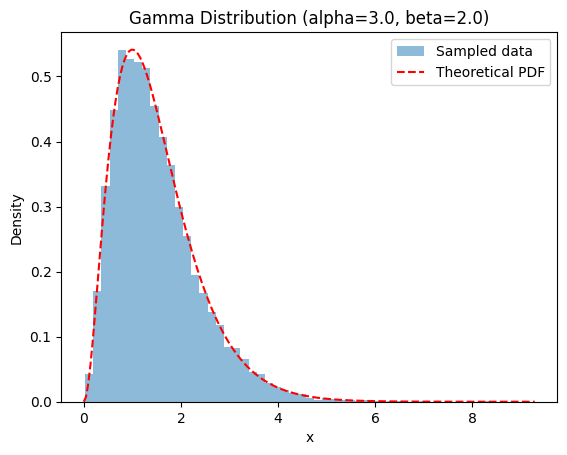

In [ ]:
# Let's create a function to plot histogram + PDF for a given set of samples
def plot_gamma_samples(samples, alpha, beta, bins=50):
    """
    Plot a histogram of 'samples' drawn from Gamma(alpha, beta),
    overlaid with the theoretical Gamma PDF.
    """
    # Histogram
    plt.hist(samples, bins=bins, density=True, alpha=0.5, label="Sampled data")

    # Plot the theoretical PDF
    x_vals = np.linspace(0, np.max(samples)*1.1, 200)
    # In scipy's parameterization, scale = 1.0/beta
    scale_param = 1.0 / beta
    pdf_vals = gamma.pdf(x_vals, a=alpha, scale=scale_param)
    plt.plot(x_vals, pdf_vals, 'r--', label="Theoretical PDF")

    plt.title(f"Gamma Distribution (alpha={alpha}, beta={beta})")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot for each parameter set
plot_gamma_samples(samples1, alpha1, beta1)
plot_gamma_samples(samples2, alpha2, beta2)
plot_gamma_samples(samples3, alpha3, beta3)

## Problem 4: Metropolis-Hastings Algorithm for Gamma Sampling.


=== Sigma = 0.01 ===
Acceptance Rate: 0.994
Sample mean = 1.359 (Theory: 1.500)
Sample var  = 0.601 (Theory: 0.750)


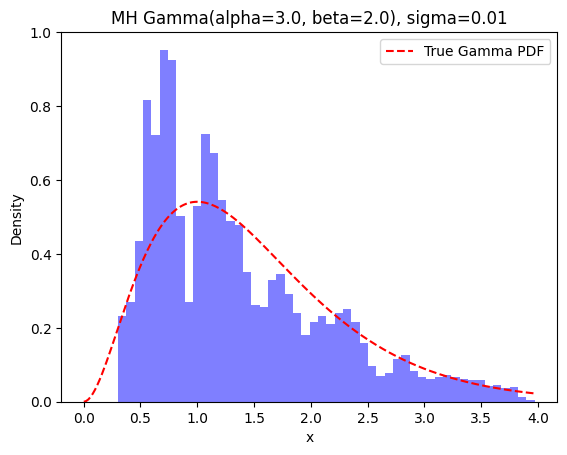


=== Sigma = 0.5 ===
Acceptance Rate: 0.747
Sample mean = 1.499 (Theory: 1.500)
Sample var  = 0.756 (Theory: 0.750)


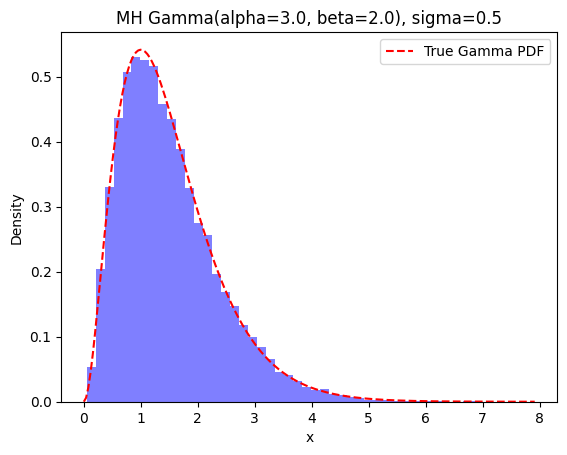


=== Sigma = 2.0 ===
Acceptance Rate: 0.339
Sample mean = 1.503 (Theory: 1.500)
Sample var  = 0.730 (Theory: 0.750)


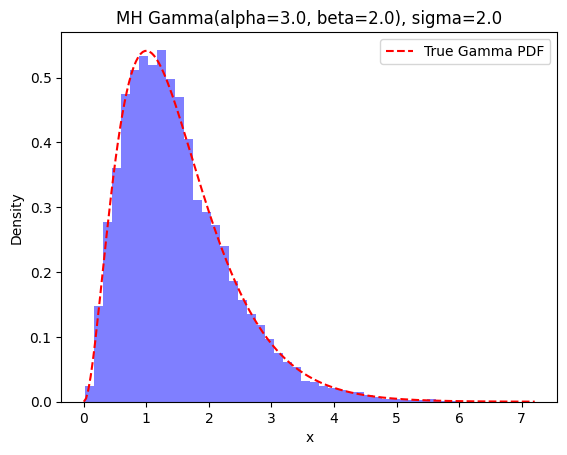

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func

def mh_gamma_sampling(alpha, beta, n_iter=10000, x0=1.0, sigma=0.5):
    """
    Metropolis-Hastings sampler for Gamma(alpha, beta) using
    a log-scale random walk proposal: log X' = log X + Normal(0, sigma^2).

    Arguments:
      alpha, beta: shape and rate of the Gamma distribution
      n_iter: number of M-H iterations
      x0: initial state
      sigma: std. dev. for the log-scale random walk
    Returns:
      samples: array of length n_iter (the M-H chain)
      accept_rate: the empirical acceptance rate
    """
    samples = np.zeros(n_iter)
    samples[0] = x0
    accepted = 0  # to count how many proposals are accepted

    for i in range(1, n_iter):
        current_x = samples[i - 1]

        # Propose: log X' = log(current_x) + eps
        eps = np.random.normal(0, sigma)
        proposed_x = np.exp(np.log(current_x) + eps)  # ensures positivity

        # log-pi(x) = (alpha-1)*log(x) - beta*x  (up to const.)
        log_pi_current = (alpha - 1) * np.log(current_x) - beta * current_x
        log_pi_proposed = (alpha - 1) * np.log(proposed_x) - beta * proposed_x

        # log-q(X' | X) for log-scale normal
        log_q_proposed_given_current = (
            - np.log(proposed_x)
            - 0.5 * np.log(2 * np.pi * sigma**2)
            - ((np.log(proposed_x) - np.log(current_x))**2 / (2 * sigma**2))
        )
        # log-q(X | X')
        log_q_current_given_proposed = (
            - np.log(current_x)
            - 0.5 * np.log(2 * np.pi * sigma**2)
            - ((np.log(current_x) - np.log(proposed_x))**2 / (2 * sigma**2))
        )

        # log of acceptance ratio
        log_accept_ratio = (
            (log_pi_proposed + log_q_current_given_proposed)
            - (log_pi_current + log_q_proposed_given_current)
        )

        # acceptance probability
        accept_ratio = np.exp(log_accept_ratio)
        accept_prob = min(1.0, accept_ratio)

        # Decide whether to accept or reject
        u = np.random.rand()
        if u <= accept_prob:
            samples[i] = proposed_x
            accepted += 1
        else:
            samples[i] = current_x

    accept_rate = accepted / (n_iter - 1)
    return samples, accept_rate

if __name__ == "__main__":
    alpha, beta = 3.0, 2.0
    n_iter = 50000
    burn_in = 1000
    x0 = 1.0

    # Change these sigma values to see "good" vs. "bad" proposals:
    sigmas = [0.01, 0.5, 2.0]

    for s in sigmas:
        # Run MH for each proposal std. dev.:
        chain, accept_rate = mh_gamma_sampling(alpha, beta, n_iter=n_iter,
                                               x0=x0, sigma=s)
        # Discard burn-in:
        chain_burned = chain[burn_in:]

        # Print acceptance rate and some statistics:
        mean_est = np.mean(chain_burned)
        var_est = np.var(chain_burned)
        theo_mean = alpha / beta
        theo_var  = alpha / (beta**2)
        print(f"\n=== Sigma = {s} ===")
        print(f"Acceptance Rate: {accept_rate:.3f}")
        print(f"Sample mean = {mean_est:.3f} (Theory: {theo_mean:.3f})")
        print(f"Sample var  = {var_est:.3f} (Theory: {theo_var:.3f})")

        # Plot histogram vs. true Gamma pdf
        plt.figure()
        plt.hist(chain_burned, bins=50, density=True, alpha=0.5, color='blue')

        x_vals = np.linspace(0.001, np.max(chain_burned), 200)
        norm_const = (beta**alpha) / gamma_func(alpha)
        pdf_vals = norm_const * (x_vals**(alpha - 1)) * np.exp(-beta * x_vals)
        plt.plot(x_vals, pdf_vals, 'r--', label='True Gamma PDF')

        plt.title(f"MH Gamma(alpha={alpha}, beta={beta}), sigma={s}")
        plt.xlabel("x")
        plt.ylabel("Density")
        plt.legend()
        plt.show()